In [104]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Topology analysis of polymer tube sections using micro-computed tomography images
## Image Guided Therapy Lab 2019 (02.09.2019 - 13.09.2019)
__Author__:             Reto Furrer<br/>
__Date created__:       02.09.2019<br/>
__Date last modified__: 06.09.2019<br/>
__Python Version__:     3.6<br/>

### Introduction
This file comes in conjunction with the Lab report `IGTLab_RetoFurrer_rep.pdf`. Coronary artery disease (CAD) is prevalent in the worldwide elderly population. In the United States, 15.5 million people (year 2016) have coronary artery diseases [1]. It is a significant cause of mortality in developed countries. However, the mortality due to CAD has gradually declined over the last few decades. Among other reasons, the reduction is caused by the timely percutaneous coronary intervention (PCI) with balloon catheters [2]. Heavily resistant coronary lesions remain a challenge in interventional cardiology [3, 4]. The inability to fully dilate a lesion can lead to adverse effects, e.g. restenosis [5]. For a successful dilatation of a resistant lesion a high force must be applied to the vessel wall [6]. To exert high forces, the rated burst pressure (RBP) of the device must be high [7]. The cardiovascular system consists of very thin structures [8]. Therefore, the crossing profile of the balloon catheter, i.e. the biggest diameter of the catheter, must be as small as possible. The smaller the crossing profile, the better peripheral coronary arteries can be reached. Designing a balloon catheter with a high pressure resistance within the size limitations, e.g. small crossing profile, is challenging. It is crucial to understand the thin structures and the topology of the polymer materials of a percutaneous transluminal coronary angioplasty (PTCA) catheter to overcome the challenges [9]. The catheter shaft, which is a polymer tube, is beside the balloon, especially crucial for a high RBP [10]. A rupture of the catheter shaft may lead to the inability to deflate the ballon [11].

The standard procedure to quantify the topology of polymer tubes is to measure the inner- and outer diameter. The outer diameter is measured with a micrometer or a two-axis laser. The inner diameter is measured with precision mandrels. The current practice can only be applied on a short endsection of the tube. Positions in the middle of the tube cannot be measured, making it difficult to quantify the topology along the tube. The topology may be assessed by a laser-ultrasonic method, which measures the wall thickness along a seamless tube at one angle of that tube [12]. The method is used in tubes with wall thicknesses of about 30 mm and high tolerances [13]. Medical images, e.g. computed tomography are used in the medical field to measure airways wall thicknesses [14, 15, 16, 17]. Micro-computed tomography (μCT) may be used to measure the topology of polymer tubes used in PTCA catheters as well.

The aim of this work is to quantitatively analyse the topology of polymer tube sections based on the outer- and inner diameter along the catheter shaft tube axis. We hypothesize that the shaft topology of a PTCA catheter can be quantified accurately by using μCT images. High resolution μCT images from catheter shaft tubes are theoretically sufficient to analyse their topology. Noise present in the raw images and the image processing algorithm itself, e.g. deviation of edge detection, may introduce some inaccuracies. However, to control the accuracy of the image processing algorithm an own algorithm to evaluate the tube topology is proposed.
In this report we present an image processing approach to quantify the topology of a PTCA catheter shaft. μCT images of a polymer tube are the basis for this analysis. In the remainder of the report the topology of two tube samples, plain and necked, are analysed. The deviation to the specification limits for both data sets is investigated. Based on the results of the algorithm, the capabilities to analyse the tubes are evaluated. 

The image processing approach consits of: (1) Filtering of the image to reduce the image modality noise. (2) Reduction of the image size to the region of interest. (3) Detection of the edges (Canny) and derive the outer diameter in x- and y-direction. (4) Removal of the information around the outer diameter and repeat the edge detection step from 3. to find the inner diameter. (5) Segment and retrive the outer and inner diameter in both, x- and y-direction, and plot results. Since this project is done in the image guided therapy lab of the Biomedical Engineering Program at Univerity of Bern, the ambition is to implement the methods and not just use existing packages, e.g. `pandas` or `OpenCV`.

## Preamble
The libraries used for this file are imported here. There may be other packages needed for the functions, called from this file. The corresponding packages are imported in the respective function file `utils.py`.

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import utils as utils # Function created for this project

# Control of the filenames and file-path
The use of different tube sections, plain and necked tubes, the following code allows to switch between the samples. According the choosen sample the file path is set. 

In [106]:
# Data set
data_set = sample = "Y" # "X" or "Y"

# Set path according to the data set
if data_set == "X":
    path = "img/X/rec/*.png"

if data_set == "Y":
    path = "img/Y/rec/*.png"
    #path = "img/phantom/*.png" 

# General setting and definition of constants
Prior to the image analysis some general information must be given, e.g. image resolution. In order to organize the data properly some folder structures are created. In the following each definition is shortely explained.

## Check whether the needed directories are present
To store and organize the produced images, e.g. segmentation, a folder structure is created. With the following code the presence of the folders is checked and if the folder is not present the folder is created

In [107]:
utils.create_directories()

# Open the file in which you want to store the files in
file = open("res/txt/results_sample_{}.txt".format(sample), "w")

## Start timer to evaluate performance 
For the evaluation of the methods it is a easy way to record the computation time. With the following, the timer is started. 

__Caution__: If the Jupyther Notebook is executed step by step, the computation time cannot be evaluated.

In [108]:
start_time = time.time()

## Voxel resolution cubic, i.e. x, y and z
The inner and inter image resolution can be expressed in a voxel. A voxel is the 3-D representation of the resolution.

In [109]:
resolution = 1.66 # in um

## Padding in x and z direction
The images might be visualy analyzed and it is important to not just see the border of the tube but rather analyse the close proximity of the tube as well. Hence a padding is introduced around the tube. The follwowing variable controls the padding size in pixel.

In [110]:
pad = 40 # in pixels

# Initialize empty lists to store the results and variables
The outer and inner diameters are calulated for each image. The results are stored in lists for each image. The empty lists are initialized here.

In [111]:
## Tube length and wall thickness
z, t_x_0, t_x_180, t_y_90, t_y_270, t = ([] for i in range(6)) 

## Outer diameter and -radius
d_o_x, d_o_y, d_o, r_o_x, r_o_y, r_o = ([] for i in range(6))

## Inner diameter and -radius
d_i_x, d_i_y, d_i, r_i_x, r_i_y, r_i = ([] for i in range(6)) 

## Contains all radii per image
radius_outer = [] 

## Init variables
end_time = start_iteration_time = elapsed_time = 0

# Read all images in the folder into array "images" depending on data_set
The order of the images matters. Hence, the images are loaded in a sorted way and stored in an array called `images`. The sample size is calculated based on the array length and stored in the variable `samplesize`

In [112]:
images = sorted(glob.glob(path))
samplesize = (np.shape(images))[0] # int with the amount of images in the path
samplesize = 100

# Loop over the whole sequence (all images) to get outer and inner diameter
The following for-loop iterates over all images stored in the array `images`. The functions used are stored and documented in the file `utils.py`. The reason is that the functions should be callable from other programms too. The program consists of the following steps:
1. Filtering of the image to reduce the image modality noise with `gaussian_filter()`.
2. Reduction of the image size to the region of interest with `crop_to_roi()`. 
3. Detection of the edges (Canny) and derive the outer diameter in x- and y-direction with `find_diameter()` 
4. Removal of the information around the outer diameter with `mask_image_circ()` 
5. Repeat the edge detection step from 3. to find the inner diameter with `find_diameter()`. 
6. Find radii of the first diameter found in the image with `find_radii()`
7. Segment and retrive the outer and inner diameter in both, x- and y-direction, and plot results with `plot_segmentation()`, `calculate_wallthickness()` and `export_results()`.

In [113]:
print("timestamp (start):", time.ctime())

for idx in range(samplesize):
    ## Start iteration timer to evaluate performance
    start_iteration_time = time.time()
        
    ## Read the original image and convert image into array
    image = plt.imread(images[idx])
    #image = plt.imread("img/Y/rec/trial1_rec2316.png")
    image = np.asarray(image)
    
    ## Print original image to a new file (path: /exp/original/*.pdf)
    utils.print_original_image(image, 
                               sample=data_set, 
                               show="False", 
                               index=idx)
    
    ## Preprocessing, i.e. filtering of the image (path: /exp/filt/gauss/*.pdf)
    img_filtered = utils.gaussian_filter(image, 
                                         sigma=4, 
                                         sample=data_set, 
                                         show="False", 
                                         index=idx)
    
    ## Crop image to region of interest (path: /exp/roi/*.pdf)
    img_crop = utils.crop_to_roi(img_filtered, 
                                 sample=data_set, 
                                 padding=pad, 
                                 show="False", 
                                 index=idx)
        
    ## calculate outer diameter and center point of the outer diameter
    d_outer, center_outer = utils.find_diameter(img_crop, 
                                                padding=pad, 
                                                sample=data_set, 
                                                show="False", 
                                                index=idx)
    
    ## Calculate outer diameter
    d_o_x_direct = d_outer[0]*resolution
    d_o_y_direct = d_outer[1]*resolution
    d_o_mean = np.mean(d_outer)*resolution
    r_o_mean = (np.mean(d_outer)/2)*resolution
    
    ## mask image to reduce information based on found outer diameter
    d_outer_min = np.minimum(d_outer[0],d_outer[1])
    masked_image = utils.mask_image(img_crop, 
                                         d_outer_min, 
                                         center_outer,
                                         mode="ellipse", # circle, ellipse or square
                                         padding=pad, 
                                         show="False", 
                                         sample=data_set, 
                                         index=idx)
    
    ## Crop image to region of interest (path: /exp/roi/*.pdf)
    img_crop_masked = utils.crop_to_roi(masked_image, 
                                        sample=data_set,
                                        sigma=7, # Check this!!!!!!!!
                                        padding=pad, 
                                        show="False", 
                                        index=idx)
    
    ## calculate inner diameter and center point of the tinner lumen
    d_inner, center_inner = utils.find_diameter(img_crop_masked, 
                                                sample=data_set, 
                                                padding=pad,
                                                sigma=7, # Check this!!!!!!
                                                show="False", 
                                                index=idx)
    
    ## Calculate outer diameter
    d_i_x_direct = d_inner[0]*resolution
    d_i_y_direct = d_inner[1]*resolution
    d_i_mean = np.mean(d_inner)*resolution
    r_i_mean = (np.mean(d_inner)/2)*resolution
    
    ## plot segmentation of the tube outer diameter and inner lumen on croped image
    utils.plot_segmentation(img_crop, 
                            d_outer, 
                            center_outer, 
                            d_inner, 
                            center_inner, 
                            padding=pad, 
                            sample=data_set,
                            show="False",
                            index=idx)
    
    ## calculate wall thickness in x and y direction
    wallthicknesses = utils.calculate_wallthickness(d_outer, 
                                                  center_outer, 
                                                  d_inner, 
                                                  center_inner)
    
    ## Calculate wallthickness in SI-unit
    t_mean = np.mean([wallthicknesses[4],wallthicknesses[5]])*resolution
    wallthickness_x_0 = wallthicknesses[0]*resolution  
    wallthickness_x_180 = wallthicknesses[1]*resolution 
    wallthickness_y_90 = wallthicknesses[2]*resolution 
    wallthickness_y_270 = wallthicknesses[3]*resolution
    
    ## Calculate position in z-direction (length)
    pos_length = idx*resolution
    
    ## Export results into text files (.txt) that was opened with create_directories()
    utils.export_results(pos_length, 
                         d_o_x_direct, 
                         d_o_y_direct, 
                         d_o_mean, 
                         r_o_mean, 
                         d_i_x_direct, 
                         d_i_y_direct, 
                         d_i_mean, 
                         r_i_mean, 
                         wallthickness_x_0, 
                         wallthickness_x_180, 
                         wallthickness_y_90, 
                         wallthickness_y_270,
                         t_mean, 
                         sample=data_set, 
                         res=resolution, 
                         index=idx,
                         file=file)
    
    ## Call function find_radii to iterate through the whole image and calculate the radius
    #radius, index = utils.find_radii(img_crop, 
    #                                 sample=data_set,
    #                                 res=resolution,
    #                                 show="False", 
    #                                 index=idx)
        
    # Append results to list for each iteration & calculate values to distance in m
    ## Tube lengt (z-axis)
    z.append(pos_length)
    
    ## outer diameter resp. outer radius
    d_o_x.append(d_o_x_direct)
    d_o_y.append(d_o_y_direct)
    d_o.append(d_o_mean)
    r_o.append(r_o_mean)
    
    ## inner diameter resp. inner radius
    d_i_x.append(d_i_x_direct)
    d_i_y.append(d_i_y_direct)
    d_i.append(d_i_mean)
    r_i.append(r_i_mean)
    
    ## wall thickness
    t.append(t_mean)
    t_x_0.append(wallthickness_x_0)
    t_x_180.append(wallthickness_x_180)
    t_y_90.append(wallthickness_y_90)
    t_y_270.append(wallthickness_y_270)
    
    ## Creates list with all the radii found with find_radii()
    #radius_outer.append(radius)
    
    ## Print the index of the loop as indication for the progress (incl. elapsed time)
    print("- {} of {} in {} sec [{}]".format((idx+1), 
                                      samplesize, 
                                      round(time.time() - start_iteration_time,2),
                                      time.ctime()))

## Stop timer and print timestempt ot the console
end_time = time.time()
print("timestamp (end):", time.ctime())

## Important: Close file to free up the memory (!)
file.close()

timestamp (start): Fri Sep  6 11:18:55 2019
- 1 of 100 in 9.88 sec [Fri Sep  6 11:19:05 2019]
- 2 of 100 in 8.25 sec [Fri Sep  6 11:19:13 2019]
- 3 of 100 in 8.2 sec [Fri Sep  6 11:19:21 2019]
- 4 of 100 in 8.63 sec [Fri Sep  6 11:19:30 2019]
- 5 of 100 in 10.2 sec [Fri Sep  6 11:19:40 2019]
- 6 of 100 in 8.31 sec [Fri Sep  6 11:19:49 2019]
- 7 of 100 in 8.04 sec [Fri Sep  6 11:19:57 2019]
- 8 of 100 in 8.41 sec [Fri Sep  6 11:20:05 2019]
- 9 of 100 in 8.37 sec [Fri Sep  6 11:20:13 2019]
- 10 of 100 in 8.19 sec [Fri Sep  6 11:20:22 2019]
- 11 of 100 in 8.34 sec [Fri Sep  6 11:20:30 2019]
- 12 of 100 in 8.04 sec [Fri Sep  6 11:20:38 2019]
- 13 of 100 in 8.11 sec [Fri Sep  6 11:20:46 2019]
- 14 of 100 in 8.17 sec [Fri Sep  6 11:20:54 2019]
- 15 of 100 in 8.16 sec [Fri Sep  6 11:21:02 2019]
- 16 of 100 in 8.02 sec [Fri Sep  6 11:21:10 2019]
- 17 of 100 in 8.34 sec [Fri Sep  6 11:21:19 2019]
- 18 of 100 in 8.23 sec [Fri Sep  6 11:21:27 2019]
- 19 of 100 in 8.15 sec [Fri Sep  6 11:21:35 201

## Overall timeout computation to evaluate performance
The timer is stopped here, because of the case were the if-loop interupts, the successive function can still be executed. Otherwise the Definition of end_time would be missing. Calculate the elapsed time and store the value in the variable `elapsed_time`. Print the variable to the console.

__Caution__: Interpret this value with caution. E.g. if the Jupyther Notebook or JupytherLab is executed step by step, the computation time cannot be evaluated.

In [114]:
elapsed_time = round(end_time - start_time,2)
print(elapsed_time,"sec",)

864.68 sec


## Print summary
In order to have a brief overview over the main results. The method `print_summary()` is called to show a summary of the results and the process in the console.

In [115]:
utils.print_summary(z, 
                    d_o_x, 
                    d_o_y,
                    d_o, 
                    r_o, 
                    d_i_x, 
                    d_i_y, 
                    d_i, 
                    r_i, 
                    t, 
                    time_c=elapsed_time, 
                    sample=data_set, 
                    res=resolution, 
                    index=idx)


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% RESULT SUMMARY (Y): 
% --------------------------
% # Inner image resolution: 1.66 um
% # Inter image resolution: 1.66 um
% # Total computation time: 864.68 sec
% 
% Outer diameter:
% - Maximum outer diameter in x-direction: 768.58 um
% - Maximum outer diameter in y-direction: 773.56 um
% - Minimum mean outer diameter: 770.24 um
% - Maximum mean outer diameter: 771.07 um
% 
% Inner diameter:
% - Maximum inner diameter in x-direction: 645.74 um
% - Maximum inner diameter in y-direction: 652.38 um
% - Minimum mean inner diameter: 647.4 um
% - Maximum mean inner diameter: 649.06 um
% 
% Wall thickness:
% - Minimum mean wall thickness: 60.59 um
% - Maximum mean wall thickness: 61.83 um
% - Variation (max-min): 1.24 um
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# Post processing, i.e. visualisation of results
The aggregated results in the summary may distort the conclusion. Hence, detail results are plotted and different visualisations of the result should help to interpret the results efficiently.

## Plot outer diameter of the tube x & y direction
The outer diameter in x- and y-direction are plotted. The further appart they are the more elliptic the found shape of the tube. If the two values are equal a perfectly round tube was found. Consider that the methods are never perfect. A presumably perfect round tube does not necessarly mean that the real tube is perfectely round. You need to check the segementation image as well to draw further conclusions.

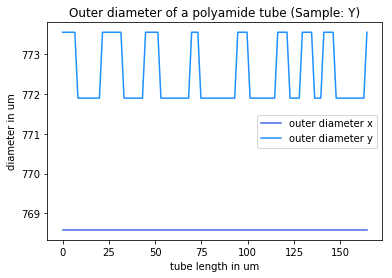

In [179]:
fig1, ax1 = plt.subplots()
ax1.plot(z, d_o_x, color="royalblue", label = "outer diameter x")
ax1.plot(z, d_o_y, color="dodgerblue", label = "outer diameter y")
ax1.legend()
ax1.set_title("Outer diameter of a polyamide tube (Sample: {})".format(sample))
ax1.set_xlabel("tube length in um")
ax1.set_ylabel("diameter in um")   
fig1.savefig('res/diag/outer_diameter_{}.pdf'.format(sample))

## Plot inner diameter of the tube x & y direction
The outer diameter in x- and y-direction are plotted. The further appart they are the more elliptic the found shape of the tube. If the two values are equal a perfectly round tube was found. Consider that the methods are never perfect. A presumably perfect round tube does not necessarly mean that the real tube is perfectely round. You need to check the segementation image as well to draw further conclusions.

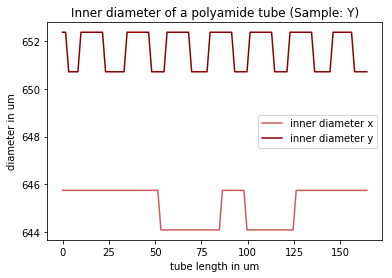

In [180]:
fig2, ax2 = plt.subplots()
ax2.plot(z, d_i_x, color="indianred", label = "inner diameter x")
ax2.plot(z, d_i_y, color="darkred", label = "inner diameter y")
ax2.legend()
ax2.set_title("Inner diameter of a polyamide tube (Sample: {})".format(sample))
ax2.set_xlabel("tube length in um")
ax2.set_ylabel("diameter in um")
fig2.savefig('res/diag/inner_diameter_{}.pdf'.format(sample))

## Plot outer & inner radius axissymmetric
The mean outer and inner radius of the tube is plotted and the tube is approximated as circular. Hence the x-axis of the plot is the rotational axis of the tube.

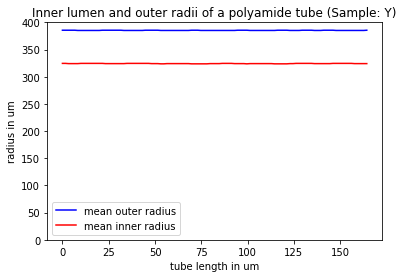

In [181]:
fig3, ax3 = plt.subplots()
ax3.plot(z, r_o, color="blue", label = "mean outer radius")
ax3.plot(z, r_i, color="red", label = "mean inner radius")
ax3.legend()
ax3.set_ylim([0,400])
ax3.set_title("Inner lumen and outer radii of a polyamide tube (Sample: {})".format(sample))
ax3.set_xlabel("tube length in um")
ax3.set_ylabel("radius in um")
fig3.savefig('res/diag/radius_mean_axissymmetric_{}.pdf'.format(sample))

## Plot outer & inner radius of a tube section
The mean outer and inner radius of the tube is plotted on a limited length `set_xlim[]`. The tube is approximated as circular and the x-axis of the plot is the rotational axis of the tube. 

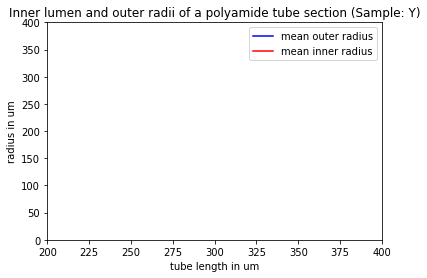

In [182]:
fig4, ax4 = plt.subplots()
ax4.plot(z, r_o, color="blue", label = "mean outer radius")
ax4.plot(z, r_i, color="red", label = "mean inner radius")
ax4.legend()
ax4.set_ylim([0,400])
ax4.set_xlim([200,400])
ax4.set_title("Inner lumen and outer radii of a polyamide tube section (Sample: {})".format(sample))
ax4.set_xlabel("tube length in um")
ax4.set_ylabel("radius in um")
fig4.savefig('res/diag/radius_mean_section_axissymmetric_{}.pdf'.format(sample))

## Plot outer & inner radius mean of a tube section
The mean outer and inner radius of the tube is plotted on a limited length `set_xlim[]`. The radii are zoomed in to observe the variation. The tube is approximated as circular and the x-axis of the plot is the rotational axis of the tube. 

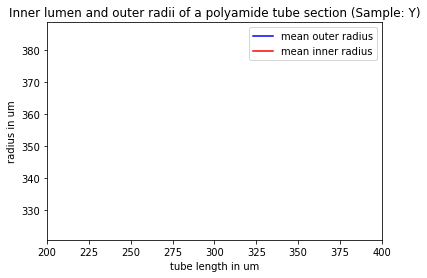

In [183]:
fig5, ax5 = plt.subplots()
ax5.plot(z, r_o, color="blue", label = "mean outer radius")
ax5.plot(z, r_i, color="red", label = "mean inner radius")
ax5.legend()
ax5.set_xlim([200,400])
ax5.set_title("Inner lumen and outer radii of a polyamide tube section (Sample: {})".format(sample))
ax5.set_xlabel("tube length in um")
ax5.set_ylabel("radius in um")
fig5.savefig('res/diag/radius_mean_section_zoom_axissymmetric_{}.pdf'.format(sample))

## Plot wall thickness of the tube
The mean wallthickness of the tube is plotted over the whole lenght of the tube. The tube is approximated as circular and the x-axis of the plot is the rotational axis of the tube. 

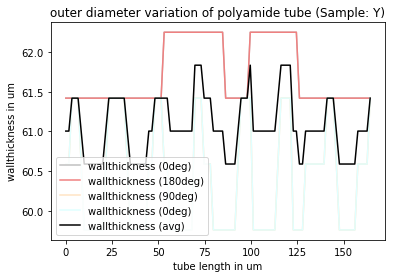

In [184]:
fig6, ax6 = plt.subplots()
ax6.plot(z, t_x_0, color="silver", label = "wallthickness (0deg)")
ax6.plot(z, t_x_180, color="lightcoral", label = "wallthickness (180deg)")
ax6.plot(z, t_y_90, color="bisque", label = "wallthickness (90deg)")
ax6.plot(z, t_y_270, color="lightcyan", label = "wallthickness (0deg)")
ax6.plot(z, t, color="black", label = "wallthickness (avg)")
ax6.legend()
ax6.set_title("outer diameter variation of polyamide tube (Sample: {})".format(sample))
ax6.set_xlabel("tube length in um")
ax6.set_ylabel("wallthickness in um")
fig6.savefig('res/diag/wallthickness_tube_{}.pdf'.format(sample))

## Plot topology of the wall thickness
The wall thickness at four angles, i.e. 0°, 90°, 180° and 270°, are shown. The wall thickness variation is indicated by a 3D plot along the tube.

__Comment:__ The radii at each slice can be found with the method `find_radii()` that returns a list of the found radii. However due to the strong interest in the wall thickness and computational reasons only 4 angles are presented.

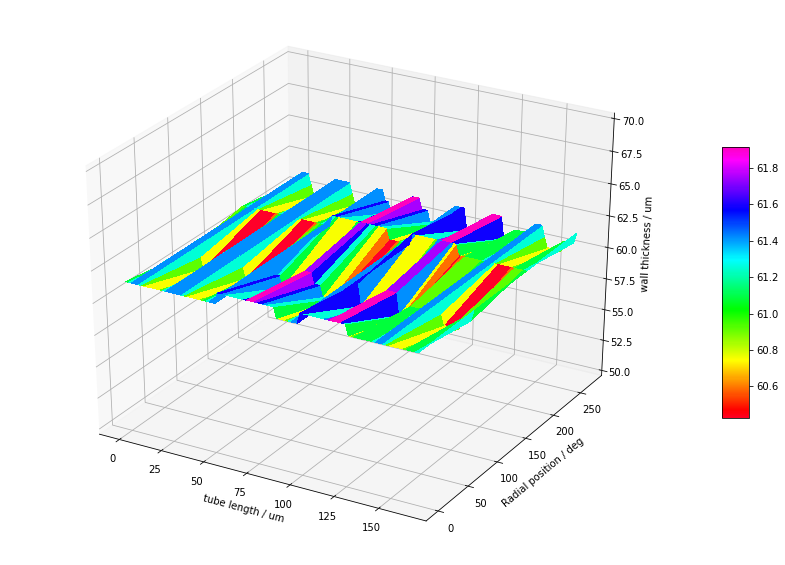

In [186]:
from mpl_toolkits import mplot3d

fig7, ax7 = plt.subplots(figsize=[15,10])
X, Y = np.meshgrid(z, [0,90,180,270])
Z = np.asarray([np.asarray(t_x_0),np.asarray(t_y_90),np.asarray(t_x_180),np.asarray(t_y_270)])
ax7 = plt.axes(projection='3d')
surface = ax7.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='gist_rainbow', edgecolor='none', antialiased=False)
ax7.set_zlim([50,70])
ax7.set_xlabel('tube length / um')
ax7.set_ylabel('Radial position / deg')
ax7.set_zlabel('wall thickness / um');
fig7.colorbar(surface, shrink=0.5, aspect=10)
plt.show()